## Approach

###### First, we transform our text into a normalized TFIDF matrix using the TfidfVectorizer class.

###### Next, we reduce the matrix down to 100 dimensions using the SVD algorithm.

###### We subsequently normalize the dimensionally-reduced output, for clustering purposes.

###### We cluster the normalized output using K-means.

###### We can K estimate by generating an Elbow plot using Mini Batch K-means, which is optimized for speed.

###### We visualize the top words in each cluster using a word cloud. All word-clouds are displayed as subplots within the single figure.

###### Words are ranked based on their summed TFIDF values across all the texts within a cluster.

###### Finally, we interpret the topic of each cluster using the word-cloud visualization. Any uninterpretable clusters are examined in more detail .

In [1]:
# questions...

# PRICE AND VALUE
# what is the relationship between points and price
# what are the best value wineries?
# where are the best value wines from
# can we recommend cheaper wines to people based on what they like?

# REGRESSION
# Can we predict price from the reviews?
# Can we predict score from the description / variety / winery etc?

# CLUSTERS
# what keywords belong to different clusters?
# how do different clusters rate
# Nearest neighbours - can we find the nearest neighbour recommendations for people

# VARIETIES
# what keywords describe each variety of wine?
# how similar are different varieties? Do they overlap?


##### Imports

In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

##### Read in the data

In [3]:
wine_df = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)

In [4]:
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


##### explore the data

In [5]:
wine_df.info()
# price and points are numeric - the rest are objects.
# note some missing data, but every wine has:
# description
# points
# title
# winery
# only one missing variety

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


##### Price vs Points

In [6]:
wine_df.describe()
# points range between 80 and 100
# price ranges between 4$ and $3300

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [7]:
# Price vs. Points
corr_matrix = wine_df.corr()
corr_matrix['price'].sort_values(ascending=False)

price     1.000000
points    0.416167
Name: price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002653EFE5088>,
      dtype=object)

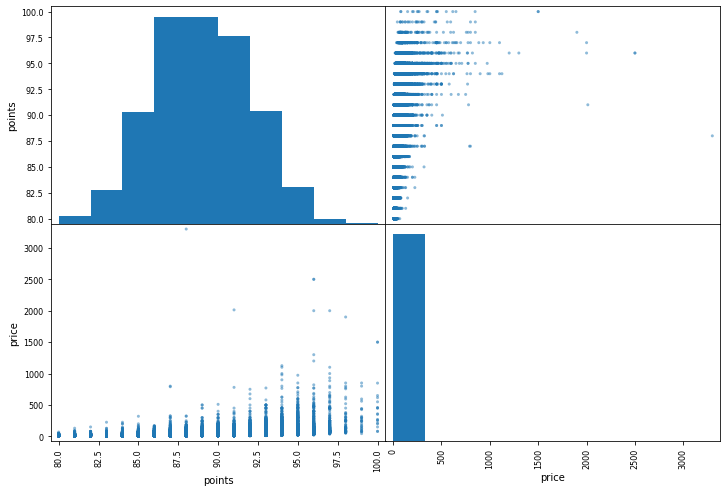

In [8]:
from pandas.plotting import scatter_matrix
attributes = ['points', 'price']
scatter_matrix(wine_df[attributes], figsize=(12,8))

##### TFIDF

In [163]:
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'aromas',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',

In [9]:
# CREATE NORMALISED TFIDF matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(['wine', 'flavors', 'aromas', 'palate',
                                            'drink', 'finish', 'drink from', 'offers',
                                            'nose', 'feels', 'drink through', 'shows',
                                            'alongside'])


tfidf_vectorizer = TfidfVectorizer(#stop_words='english'
                                   stop_words = stop_words,
                                   ngram_range=(1, 2),
                                   max_df=0.7, min_df=5, max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(wine_df['description'])
tfidf_matrix.shape

C:\Users\Phil\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['feels', 'nose'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(129971, 10000)

In [10]:
# Get VOCAB LIST
vocab_list = tfidf_vectorizer.get_feature_names()
len(vocab_list)

10000

In [11]:
TFIDF_sums = np.sum(tfidf_matrix, axis=0)
TFIDF_sums = np.ravel(TFIDF_sums)
print(TFIDF_sums.shape)

vocab_TFIDF = pd.Series(TFIDF_sums, index = vocab_list)

(10000,)


In [12]:
vocab_TFIDF.sort_values(ascending=False).head(30)

fruit         3467.072592
acidity       2785.577966
tannins       2463.198199
cherry        2444.370095
black         2434.706002
ripe          2393.774752
red           2089.587218
spice         1847.406286
notes         1837.089060
dry           1822.415138
fresh         1821.444485
rich          1775.917480
oak           1767.506792
berry         1745.820706
nose          1654.395418
soft          1604.022303
plum          1574.891563
sweet         1558.504194
fruits        1542.771362
apple         1541.895010
light         1524.128122
crisp         1513.507778
texture       1441.590363
white         1439.152532
blackberry    1419.750433
citrus        1405.849619
blend         1357.476203
bodied        1352.554431
dark          1345.765240
bright        1300.437141
dtype: float64

##### Reduce dimensionality with SVD

In [13]:
# We can't compute the 'all by all' cosine similarities as the matrix
# will be too big. So we need to reduce the dimensionality of the vocab.

np.random.seed(0)
from sklearn.decomposition import TruncatedSVD

shrunk_matrix = TruncatedSVD(n_components=100).fit_transform(tfidf_matrix)
print(f"We've dimensionally-reduced a {tfidf_matrix.shape[1]}-column "
      f"{type(tfidf_matrix)} matrix.")
print(f"Our output is a {shrunk_matrix.shape[1]}-column "
      f"{type(shrunk_matrix)} matrix, with shape:", shrunk_matrix.shape)

We've dimensionally-reduced a 10000-column <class 'scipy.sparse.csr.csr_matrix'> matrix.
Our output is a 100-column <class 'numpy.ndarray'> matrix, with shape: (129971, 100)


##### Normalise the dimensionally-reduced output for clustering purposes

In [14]:
from sklearn.preprocessing import normalize
shrunk_norm_matrix = normalize(shrunk_matrix)
magnitude = np.linalg.norm(shrunk_norm_matrix[0])
print(f"The magnitude of the first row is {magnitude:.2f}")

The magnitude of the first row is 1.00


##### Find clusters of similar texts

In [15]:
# If 2 vectors are normalized, then their Euclidean distance 
# is an adequate substitute for cosine similarity. 
# However, this is not the case for non-normalized vectors. 
# Thus, we should never apply K-means to text-derived matrices
# if these matrices have not been normalized.

In [109]:
# Plot an elbow curve with mini batch k means

np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans

k_values = range(1, 100)
inertia_values = [MiniBatchKMeans(k).fit(shrunk_norm_matrix).inertia_
                  for k in k_values]

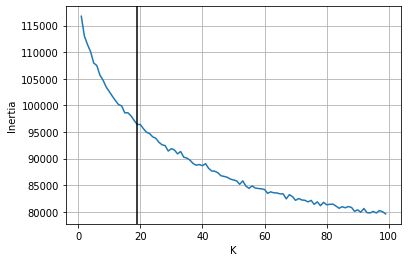

In [200]:
plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.axvline(19, c='k')
plt.grid(True)
plt.show()

In [135]:
num_clusters = 19

In [136]:
# Run k means clustering for k = 18
np.random.seed(0)
cluster_model = KMeans(n_clusters=num_clusters)
clusters = cluster_model.fit_predict(shrunk_norm_matrix) # carry out kmeans and get clusters
print(clusters.shape)

clusters_df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters}) 
clusters_df.head(15)

(129971,)


,Index,Cluster
0,0,17
1,1,11
2,2,7
3,3,8
4,4,4
5,5,4
6,6,18
7,7,11
8,8,5
9,9,17


In [182]:
wine_df['Cluster'] = clusters
wine_df

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Cluster,keyphrases
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,17,"[(Aromas), (include), (tropical, fruit), (broo..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,11,"[(ripe), (fruity), (wine), (smooth), (structur..."
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,7,"[(Tart), (snappy), (flavors), (flesh, and, rin..."
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,8,"[(Pineapple, rind), (pith, and, orange, blosso..."
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,4,"[(regular, bottling), (2012), (comes, across),..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),8,"[(Notes), (honeysuckle, and, cantaloupe), (swe..."
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,10,"[(Citation), (given), (as, much), (decade), (b..."
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,7,"[(drained), (gravel, soil), (gives), (wine), (..."
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,11,"[(dry, style), (Pinot, Gris), (crisp), (acidit..."


In [115]:
# Check relationship between clusters and wine varieties
cluster_counts = wine_df.groupby(by = ['Cluster', 'variety']).count().sort_values(by =['Cluster', 'winery'], ascending=[True, False])
cluster_counts

country  description  designation  points  \
Cluster variety                                                               
0       Cabernet Sauvignon            719          719          451     719   
        Pinot Noir                    419          419          328     419   
        Syrah                         406          406          298     406   
        Red Blend                     316          316          273     316   
        Bordeaux-style Red Blend      262          262          151     262   
...                                   ...          ...          ...     ...   
26      Tinto del Pais                  1            1            1       1   
        Touriga Nacional                1            1            1       1   
        Trincadeira                     1            1            1       1   
        Uva di Troia                    1            1            1       1   
        Vranac                          0            1            1       1   

                                  price  province  region_1  region_2  \
Cluster variety                                                         
0       Cabernet Sauvignon          713       719       669       593   
        Pinot Noir                  414       419       380       301   
        Syrah                       401       406       367       309   
        Red Blend                   300       316       275       146   
        Bordeaux-style Red Blend    163       262       248        55   
...                                 ...       ...       ...       ...   
26      Tinto del Pais                1         1         1         0   
        Touriga Nacional              1         1         0         0   
        Trincadeira                   1         1         0         0   
        Uva di Troia                  1         1         1         0   
        Vranac                        1         0         0         0   

                                  taster_name  taster_twitter_handle  title  \
Cluster variety                                                               
0       Cabernet Sauvignon                592                    591    719   
        Pinot Noir                        394                    393    419   
        Syrah                             361                    361    406   
        Red Blend                         251                    251    316   
        Bordeaux-style Red Blend          243                    239    262   
...                                       ...                    ...    ...   
26      Tinto del Pais                      1                      1      1   
        Touriga Nacional                    1                      1      1   
        Trincadeira                         1                      1      1   
        Uva di Troia                        1                      1      1   
        Vranac                              1                      1      1   

                                  winery  keyphrases  
Cluster variety                                       
0       Cabernet Sauvignon           719         719  
        Pinot Noir                   419         419  
        Syrah                        406         406  
        Red Blend                    316         316  
        Bordeaux-style Red Blend     262         262  
...                                  ...         ...  
26      Tinto del Pais                 1           1  
        Touriga Nacional               1           1  
        Trincadeira                    1           1  
        Uva di Troia                   1           1  
        Vranac                         1           1  

[4126 rows x 13 columns]

##### TFIDF for each cluster

In [116]:
tfidf_matrix

<129971x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3434480 stored elements in Compressed Sparse Row format>

In [178]:
def rank_words_by_tfidf(indices, word_list=vocab_list, max_words = 100):
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    data = {'Word': word_list,
            'Summed TFIDF': summed_tfidf}
    return pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False).head(max_words)

rank_words_by_tfidf(cluster_13_indices, word_list=vocab_list)

# df_ranked_words_0 = rank_words_by_tfidf(cluster_0_indices)
# df_ranked_words_0.head(20)

,Word,Summed TFIDF
268,acidity,507.796127
4052,fruity,452.055269
2445,crisp,418.684438
7202,ready,369.187296
1761,character,332.013627
...,...,...
7464,right,52.799398
738,apéritif,52.788654
4080,fruity ready,52.044214
6317,open,51.828121


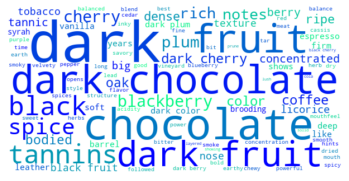

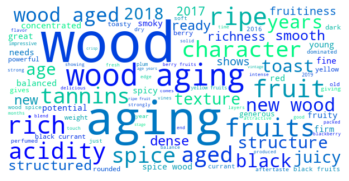

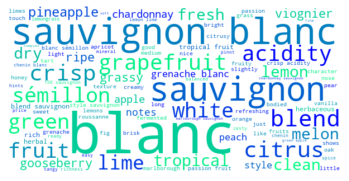

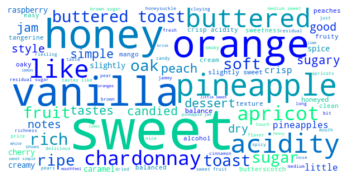

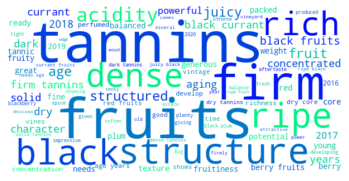

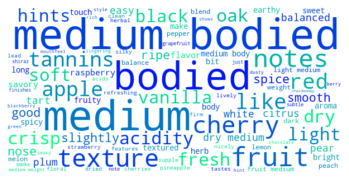

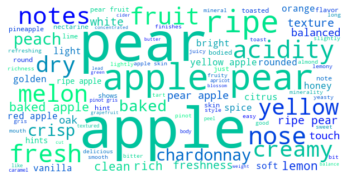

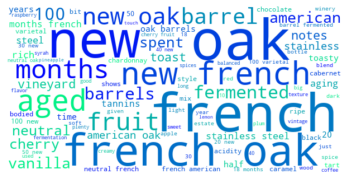

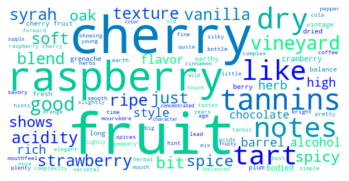

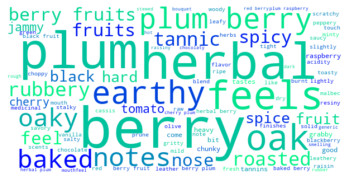

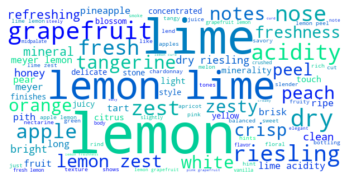

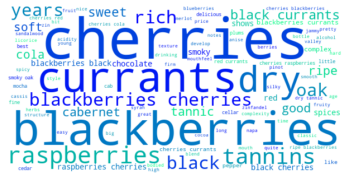

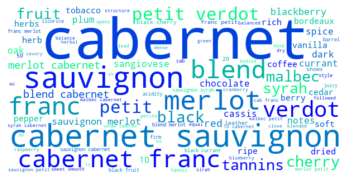

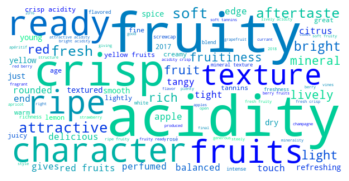

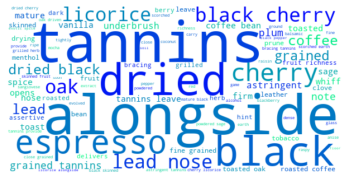

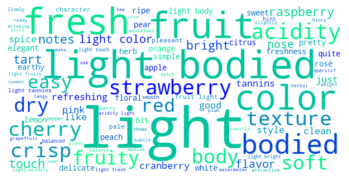

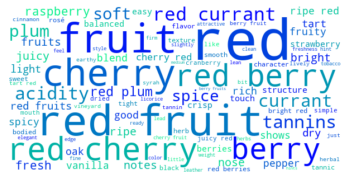

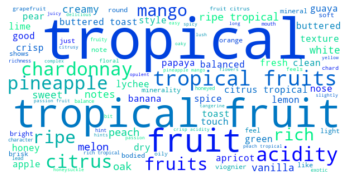

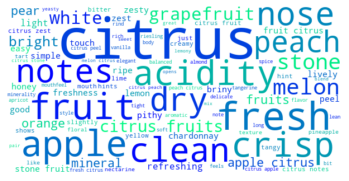

In [179]:
#np.random.seed(1)

def cluster_to_image(cluster_number = 0, max_words=100):
    indices = wine_df[wine_df['Cluster'] == cluster_number].index
    df_ranked_words = rank_words_by_tfidf(indices)[:max_words]
    words_to_score = {word: score
                      for word, score in df_ranked_words[:max_words].values}
    cloud_generator = WordCloud(background_color='white',
                                #color_func=_color_func,
                                random_state=1,
                                min_word_length=2,
                                include_numbers=True, 
                                max_font_size=100,
                                max_words=100,
                                relative_scaling = 0.4,  #0=ranks only, 1=freq only, 0.5=mix
                                colormap = "winter",
                                width=600, height=300,
                                prefer_horizontal=1)
    
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    plt.axis("off")
    wordcloud_image.to_file("keyphrases_" + str(cluster_number) + ".png")
    plt.imshow(wordcloud_image, interpolation="bilinear")
    plt.show()
    
    return wordcloud_image

def _color_func(*args, **kwargs):
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])

for cluster_id in range(0, num_clusters):
    wordcloud_image = cluster_to_image(cluster_id)
#     wordcloud.to_file("keyphrases_" + str(cluster) + ".png")
#     plt.imshow(wordcloud_image, interpolation="bilinear")
#     plt.show()

##### Calculate Keyphrases for each wine

In [25]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
from spacy.tokens import Doc, Token, Span
from spacy import util

In [26]:
#### INITIALISE THE MATCHER
matcher = Matcher(nlp.vocab) # Initialize the matcher with the shared vocab


#### DEFINE PATTERNS TO MATCH

noun_or_propn = [
                    #{"LEMMA": "the", "OP": "*"},
                    {"POS": "ADJ", "OP": "?"},
                    {"POS": {'IN':["PROPN", "NOUN"]}},
                    {"POS": {'IN': ["PROPN", "NOUN"]}, "OP": "*"}
                ]

neg_noun_or_propn = [
                    {"LEMMA": {'IN': ["not", "nothing"]}},
                    {"POS": "DET", "OP": "?"},
                    {"POS": "ADJ", "OP": "?"},
                    {"POS": {'IN':["PROPN", "NOUN"]}},
                    {"POS": {'IN': ["PROPN", "NOUN"]}, "OP": "*"}
                ]

noun_and_noun = [{"POS": {'IN':["PROPN", "NOUN"]}},
                 {"LOWER": "and"},
                       {"POS": {'IN': ["PROPN", "NOUN"]}, "OP": "+"}]


neg_noun_and_noun = [{"LEMMA": {'IN': ["not", "nothing"]}},
                     {"POS": {'IN':["PROPN", "NOUN"]}},
                     {"LOWER": "and"},
                     {"POS": {'IN': ["PROPN", "NOUN"]}, "OP": "+"}]


verb_pattern = [{"POS": "VERB"},
                {"POS": "VERB", "OP": "*"},
                {"POS": "ADP", "OP": "?"}]

neg_verb_pattern = [{"LEMMA": {'IN': ["not", "nothing"]}},
                    {"POS": "ADV", "OP": "?"},
                    {"POS": "AUX", "OP": "?"},
                    {"POS": "PART", "OP": "?"},
                    {"POS": "VERB"},
                    {"LEMMA": "not", "OP": "?"},
                    {"POS": "VERB", "OP": "?"},
                    {"POS": "ADP", "OP": "?"}]

adjective_pattern = [{"POS": "ADV", "OP": "?"},
                        {"POS": "ADJ"},
                       {"POS": "ADV", "OP": "?"}]
                
neg_adjective_pattern = [{"LEMMA": {'IN': ["not", "nothing"]}},
                        {"POS": "ADV", "OP": "?"},
                        {"POS": "ADJ"},
                        {"POS": "ADV", "OP": "?"}]

neg_pattern = [{"LEMMA": {'IN': ["not", "nothing"]}}]

num_and_noun = [
                    {"POS": "NUM", "OP": "+"},
                    {"POS": {'IN':["PROPN", "NOUN"]}},
                    {"POS": {'IN': ["PROPN", "NOUN"]}, "OP": "*"}
                ]

noun_and_num = [
                    {"POS": {'IN':["PROPN", "NOUN"]}},
                    {"POS": {'IN': ["PROPN", "NOUN"]}, "OP": "*"},
                    {"POS": "NUM", "OP": "+"}
                ]


number_only = [
                    {"POS": "NUM", "OP": "+"}
                ]

                        
## ADD THE ABOVE PATTERNS TO THE MATCHER
matcher.add("Nouns or Proper Nouns", None, noun_or_propn)
matcher.add("Negative Noun", None, neg_noun_or_propn)
matcher.add("Noun and Noun", None, noun_and_noun)
matcher.add("Noun and Noun", None, neg_noun_and_noun)
matcher.add("Verbs", None, verb_pattern) 
matcher.add("Negative Verbs", None, neg_verb_pattern) 
matcher.add("Adjective and optional adverb", None, adjective_pattern)  
matcher.add("Negative Adjective", None, neg_adjective_pattern)  
matcher.add("Negative", None, neg_pattern)  
matcher.add("Number and noun", None, num_and_noun)  
matcher.add("Noun and Number", None, noun_and_num)  
matcher.add("Number only", None, number_only) 

In [27]:
## Add Keyphrases Matcher to Pipeline
keyphrases=[]

# Define the custom component
def keyphrase_detector(doc):
    # Apply the matcher to the doc
    matches = matcher(doc)
    # Create a Span for each match and assign the label "KEYPHRASE"
    matchedspans = [Span(doc, start, end, label="KEYPHRASE") for match_id, start, end in matches]
    ### FREMOVE OVERLAPPED KEYPHRASES
    filtered = util.filter_spans(matchedspans)
    #print(filtered)
    keyphrases.append(filtered)
    # SET THE SPAN AS KEYPHRASE
    #spans.is_keyphrase = True
    return doc

# Add the component to the pipeline after the "ner" component
nlp.add_pipe(keyphrase_detector, after="ner")
#print(nlp.pipe_names)

In [28]:
Counter = 0
for doc in nlp.pipe(wine_df['description'].astype('unicode').values, batch_size=50,
                        n_threads=-1):
    if doc.is_parsed:
        Counter += 1
        if Counter % 5000 == 0:
            print('Successfully parsed:', Counter)
        
    
wine_df['keyphrases'] = keyphrases

Successfully parsed: 5000
Successfully parsed: 10000
Successfully parsed: 15000
Successfully parsed: 20000
Successfully parsed: 25000
Successfully parsed: 30000
Successfully parsed: 35000
Successfully parsed: 40000
Successfully parsed: 45000
Successfully parsed: 50000
Successfully parsed: 55000
Successfully parsed: 60000
Successfully parsed: 65000
Successfully parsed: 70000
Successfully parsed: 75000
Successfully parsed: 80000
Successfully parsed: 85000
Successfully parsed: 90000
Successfully parsed: 95000
Successfully parsed: 100000
Successfully parsed: 105000
Successfully parsed: 110000
Successfully parsed: 115000
Successfully parsed: 120000
Successfully parsed: 125000


In [29]:
wine_df

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Cluster,keyphrases
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,0,"[(Aromas), (include), (tropical, fruit), (broo..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1,"[(ripe), (fruity), (wine), (smooth), (structur..."
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,0,"[(Tart), (snappy), (flavors), (flesh, and, rin..."
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,0,"[(Pineapple, rind), (pith, and, orange, blosso..."
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,3,"[(regular, bottling), (2012), (comes, across),..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),0,"[(Notes), (honeysuckle, and, cantaloupe), (swe..."
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,3,"[(Citation), (given), (as, much), (decade), (b..."
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,1,"[(drained), (gravel, soil), (gives), (wine), (..."
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,1,"[(dry, style), (Pinot, Gris), (crisp), (acidit..."


##### Create Keyphrase Dict to Count Keyphrases

In [30]:
wine_df['keyphrases'][0]

[Aromas,
 include,
 tropical fruit,
 broom,
 brimstone,
 dried,
 herb,
 palate,
 n't overly expressive,
 offering,
 unripened apple,
 citrus,
 dried,
 sage,
 brisk acidity]

In [31]:
keyphrase_dict = {}

def get_keyphrases(keyphase_list):
    for keyphrase in keyphase_list:
        #print(keyphrase)
        if keyphrase.text.lower() in keyphrase_dict:
            keyphrase_dict[keyphrase.text.lower()] += 1
        else:
            keyphrase_dict[keyphrase.text.lower()] = 1

#get_keyphrases(wine_df['keyphrases'][0])
wine_df['keyphrases'].apply(lambda x: get_keyphrases(x))
keyphrase_dict

for sw in stop_words:
    keyphrase_dict.pop(sw, None)

In [32]:
# create dictionary of multi-word keyphrases
keyphrases_multi = {k:v for k,v in keyphrase_dict.items() if len(k.split()) >= 2 }

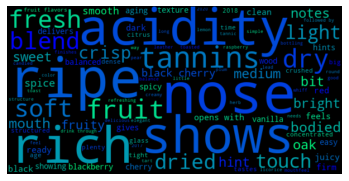

In [33]:
wordcloud = WordCloud(# stopwords=stopwordlist,
                      min_word_length=2,
                      include_numbers=True, 
                      max_font_size=100,
                      max_words=100,
                      relative_scaling = 0.4,  #0=ranks only, 1=freq only, 0.5=mix
                      colormap = "winter",
                      background_color="black", 
                      width=600, height=300,
                      prefer_horizontal=1)

wordcloud.generate_from_frequencies(frequencies=keyphrase_dict) # input the dictionary of word counts
#text_for_cloud = ''.join(df['LemmaJoined'][questionmask==True])
#wordcloud.generate(text_for_cloud)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# wordcloud.to_file(path + savefolder + "keyphrases_multi.png")

##### Cluster by Cluster Keyphrases

In [34]:
keyphrases_cluster0 = {}
keyphrases_cluster1 = {}
keyphrases_cluster2 = {}
keyphrases_cluster3 = {}
keyphrases_cluster4 = {}
keyphrases_cluster5 = {}
keyphrases_cluster6 = {}
keyphrases_cluster7 = {}
keyphrases_cluster8 = {}
keyphrases_cluster9 = {}
keyphrases_cluster10 = {}
keyphrases_cluster11 = {}
keyphrases_cluster12 = {}
keyphrases_cluster13 = {}
keyphrases_cluster14 = {}
keyphrases_cluster15 = {}
keyphrases_cluster16 = {}

keyphrases_cluster_list = [keyphrases_cluster0,
                           keyphrases_cluster1,
                          keyphrases_cluster2,
                          keyphrases_cluster3,
                          keyphrases_cluster4,
                          keyphrases_cluster5,
                          keyphrases_cluster6,
                           keyphrases_cluster7,
                           keyphrases_cluster8,
                           keyphrases_cluster9,
                           keyphrases_cluster10,
                           keyphrases_cluster11,
                           keyphrases_cluster12,
                           keyphrases_cluster13,
                           keyphrases_cluster14,
                           keyphrases_cluster15,
                           keyphrases_cluster16
                          ]

def get_keyphrases(keyphase_list, keyphrases_cluster_dict):
    for keyphrase in keyphase_list:
        #print(wine_df)
        if  keyphrase.text.lower() in keyphrases_cluster_dict:
            keyphrases_cluster_dict[keyphrase.text.lower()] += 1
        else:
            keyphrases_cluster_dict[keyphrase.text.lower()] = 1

#get_keyphrases(wine_df['keyphrases'][0])

for cluster in range(12):
    keyphrases_cluster_dict = keyphrases_cluster_list[cluster]
    wine_df[wine_df['Cluster'] == cluster]['keyphrases'].apply(lambda x: get_keyphrases(x, keyphrases_cluster_dict))

keyphrases_cluster0

{'aromas': 4058,
 'include': 196,
 'tropical fruit': 842,
 'broom': 8,
 'brimstone': 23,
 'dried': 1523,
 'herb': 320,
 'palate': 9847,
 "n't overly expressive": 3,
 'offering': 581,
 'unripened apple': 1,
 'citrus': 2313,
 'sage': 132,
 'brisk acidity': 365,
 'tart': 905,
 'snappy': 102,
 'flavors': 4322,
 'flesh and rind dominate': 1,
 'green pineapple': 11,
 'pokes through': 7,
 'crisp acidity': 975,
 'underscoring': 11,
 'wine': 9069,
 'stainless': 152,
 'steel': 115,
 'fermented': 609,
 'pineapple rind': 5,
 'pith and orange blossom': 1,
 'start off': 5,
 'bit': 1404,
 'more opulent': 7,
 'notes': 1765,
 'honey': 1428,
 'drizzled': 19,
 'guava': 111,
 'mango giving': 1,
 'way': 652,
 'slightly astringent': 12,
 'semidry': 14,
 'finish': 7833,
 'savory': 355,
 'thyme notes': 2,
 'accent': 123,
 'sunnier flavors': 1,
 'preserved': 97,
 'peach': 1707,
 'brisk': 645,
 'dry wine': 217,
 'fruity': 1283,
 'fresh': 4158,
 'elegant': 681,
 'footprint': 3,
 'great depth': 22,
 'flavor': 430

In [39]:
keyphrases_cluster0['nose']

5314

5314


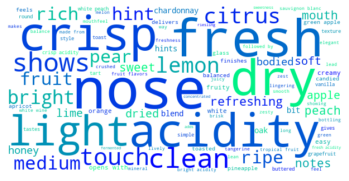

60


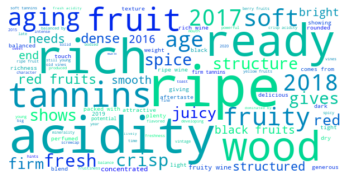

3018


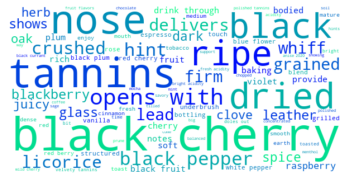

4489


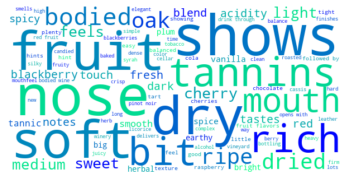

522


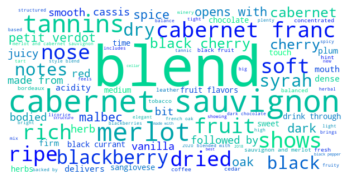

In [43]:
wordcloud = WordCloud(# stopwords=stopwordlist,
                      min_word_length=2,
                      include_numbers=True, 
                      max_font_size=100,
                      max_words=100,
                      relative_scaling = 0.4,  #0=ranks only, 1=freq only, 0.5=mix
                      colormap = "winter",
                      background_color="white", 
                      width=600, height=300,
                      prefer_horizontal=1)

for cluster in range(num_clusters):
    for sw in stop_words:
        if sw in keyphrases_cluster_list[cluster]:
            del keyphrases_cluster_list[cluster][sw]
        #keyphrases_cluster_list[cluster].pop(sw, None)
    print(keyphrases_cluster_list[cluster]['nose'])
    wordcloud.generate_from_frequencies(frequencies=keyphrases_cluster_list[cluster]) # input the dictionary of word counts
#text_for_cloud = ''.join(df['LemmaJoined'][questionmask==True])
#wordcloud.generate(text_for_cloud)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file("keyphrases_" + str(cluster) + ".png")

##### Examine Cluster Data

In [183]:
clusters_one_hot = pd.get_dummies(wine_df['Cluster'])
clusters_one_hot

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
129967,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
129968,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
129969,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [184]:
varieties = wine_df['variety']
varieties_by_cluster = pd.merge(left = varieties, right = clusters_one_hot, how = 'left', left_index=True, right_index = True)

In [185]:
varieties_by_cluster

,variety,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,White Blend,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Portuguese Red,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Pinot Gris,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Riesling,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Pinot Noir,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Riesling,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
129967,Pinot Noir,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
129968,Gewürztraminer,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
129969,Pinot Gris,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [186]:
grouped_varieties_by_cluster = varieties_by_cluster.groupby('variety').sum()
grouped_varieties_by_cluster

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
variety,,,,,,,,,,,,,,,,,,,
Abouriou,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Agiorgitiko,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,47.0,1.0,3.0,0.0,8.0,1.0,0.0,0.0,1.0
Aglianico,0.0,2.0,6.0,0.0,4.0,4.0,0.0,1.0,0.0,1.0,59.0,11.0,36.0,17.0,78.0,1.0,0.0,1.0,138.0
Aidani,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Airen,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zinfandel,13.0,10.0,267.0,48.0,54.0,2.0,19.0,4.0,0.0,436.0,659.0,55.0,562.0,132.0,348.0,104.0,1.0,0.0,0.0
Zlahtina,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Zweigelt,0.0,11.0,4.0,28.0,0.0,1.0,2.0,4.0,1.0,3.0,84.0,21.0,3.0,7.0,24.0,9.0,0.0,6.0,1.0


In [187]:
norm_varieties_by_cluster = grouped_varieties_by_cluster.div(grouped_varieties_by_cluster.sum(axis=1), axis=0)
norm_varieties_by_cluster

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
variety,,,,,,,,,,,,,,,,,,,
Abouriou,0.00000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
Agiorgitiko,0.00000,0.000000,0.000000,0.000000,0.031746,0.000000,0.000000,0.000000,0.000000,0.000000,0.746032,0.015873,0.047619,0.000000,0.126984,0.015873,0.000000,0.000000,0.015873
Aglianico,0.00000,0.005571,0.016713,0.000000,0.011142,0.011142,0.000000,0.002786,0.000000,0.002786,0.164345,0.030641,0.100279,0.047354,0.217270,0.002786,0.000000,0.002786,0.384401
Aidani,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Airen,0.00000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zinfandel,0.00479,0.003685,0.098379,0.017686,0.019897,0.000737,0.007001,0.001474,0.000000,0.160648,0.242815,0.020265,0.207074,0.048637,0.128224,0.038320,0.000368,0.000000,0.000000
Zlahtina,0.00000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
Zweigelt,0.00000,0.052632,0.019139,0.133971,0.000000,0.004785,0.009569,0.019139,0.004785,0.014354,0.401914,0.100478,0.014354,0.033493,0.114833,0.043062,0.000000,0.028708,0.004785


In [188]:
varieties_counts_and_percents = pd.merge(left = grouped_varieties_by_cluster,
                                         right = norm_varieties_by_cluster,
                                         how = 'left',
                                         left_index=True, right_index = True)

cluster_number_headers = []
cluster_percents_headers = []

for i in range(num_clusters):
    cluster_number_headers.append('Cluster Count ' + str(i))
    cluster_percents_headers.append('Cluster Percent ' + str(i))

combined_headers = cluster_number_headers + cluster_percents_headers
varieties_counts_and_percents.columns = combined_headers

In [189]:
varieties_counts_and_percents

,Cluster Count 0,Cluster Count 1,Cluster Count 2,Cluster Count 3,Cluster Count 4,Cluster Count 5,Cluster Count 6,Cluster Count 7,Cluster Count 8,Cluster Count 9,...,Cluster Percent 9,Cluster Percent 10,Cluster Percent 11,Cluster Percent 12,Cluster Percent 13,Cluster Percent 14,Cluster Percent 15,Cluster Percent 16,Cluster Percent 17,Cluster Percent 18
variety,,,,,,,,,,,,,,,,,,,,,
Abouriou,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
Agiorgitiko,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.746032,0.015873,0.047619,0.000000,0.126984,0.015873,0.000000,0.000000,0.015873
Aglianico,0.0,2.0,6.0,0.0,4.0,4.0,0.0,1.0,0.0,1.0,...,0.002786,0.164345,0.030641,0.100279,0.047354,0.217270,0.002786,0.000000,0.002786,0.384401
Aidani,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Airen,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zinfandel,13.0,10.0,267.0,48.0,54.0,2.0,19.0,4.0,0.0,436.0,...,0.160648,0.242815,0.020265,0.207074,0.048637,0.128224,0.038320,0.000368,0.000000,0.000000
Zlahtina,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
Zweigelt,0.0,11.0,4.0,28.0,0.0,1.0,2.0,4.0,1.0,3.0,...,0.014354,0.401914,0.100478,0.014354,0.033493,0.114833,0.043062,0.000000,0.028708,0.004785


In [98]:
## TRY A FEW OTHER CLUSTERINGS

In [99]:
## AND TRY WORD CLOUDS BASED ON TFIDF / N-GRAMS IN SK LEARN

In [191]:
import plotly.offline as pyo
import plotly.graph_objs as go


## INSERT CALLBACK ON CLUSTER
sorted = varieties_counts_and_percents.sort_values(by='Cluster Count 2', ascending=False).head(15)

ys = sorted.index
print(ys)
xs = sorted['Cluster Count 2']
print(xs)

x2 = sorted['Cluster Percent 2']

traces = []

data = [go.Bar(
    x = xs,
    # y = sorted_predictors['Unique_Words'],
    orientation = 'h',
    text = ys,
    textposition = 'outside',
    textfont=dict(
        #family="sans serif",
        size=16,
        #color="crimson"
    ),
    marker=dict(color = xs,
                colorbar=dict(
                    title="No. of Mentions"
                        ),
                colorscale="Viridis",
                cmax = 2000,
                cmin = 0,)
        )
       ]



# data = [go.Scatter(
#     x = x2,
#     y = ys,
#     text = ys,
#     mode='markers',
#  #   textposition = 'outside',
#     textfont=dict(
#         #family="sans serif",
#         size=16,
#         #color="crimson"
#     ),
#     marker=dict(color = xs,
#                 size = 30,
#                 colorbar=dict(
#                     title="No. of Mentions"
#                         ),
#                 colorscale="Viridis",
#                 cmax = 2000,
#                 cmin = 0,)
#         )
#        ]



layout = go.Layout(
    title = 'Most Prevalent Wine Varieties in Cluster', # Graph title
    xaxis = dict(title = 'Number of Wines in Cluster',
                 showticklabels=True,
                 showgrid=False), # x-axis label
    yaxis = dict(title = 'Wine Variety',
                 autorange='reversed',
                 showticklabels=False), # y-axis label
    hovermode ='closest' # handles multiple points landing on the same vertical
)

fig = go.Figure(data=data, layout=layout)

fig.update_layout(
    coloraxis_showscale=True,
    title={
        #'text': "Plot Title",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

pyo.plot(fig, filename='bar.html')

Index(['Chardonnay', 'Riesling', 'Sauvignon Blanc', 'White Blend', 'Viognier',
       'Sparkling Blend', 'Zinfandel', 'Gewürztraminer', 'Pinot Noir',
       'Pinot Gris', 'Rosé', 'Cabernet Sauvignon', 'Moscato', 'Red Blend',
       'Pinot Grigio'],
      dtype='object', name='variety')
variety
Chardonnay            2767.0
Riesling               773.0
Sauvignon Blanc        462.0
White Blend            347.0
Viognier               298.0
Sparkling Blend        269.0
Zinfandel              267.0
Gewürztraminer         260.0
Pinot Noir             211.0
Pinot Gris             203.0
Rosé                   198.0
Cabernet Sauvignon     187.0
Moscato                171.0
Red Blend              171.0
Pinot Grigio           114.0
Name: Cluster Count 2, dtype: float64


'bar.html'

##### Average Score by Cluster

In [192]:
scores_and_clusters = pd.merge(left = wine_df['Cluster'], right = wine_df['points'], how = 'left', left_index=True, right_index = True)
scores_and_clusters['points'] = pd.to_numeric(scores_and_clusters['points'])

In [193]:
cluster_ave_scores = scores_and_clusters.groupby('Cluster').mean()
cluster_ave_scores

,points
Cluster,
0,89.078947
1,89.632564
2,87.216934
3,87.751902
4,86.660088
5,87.826896
6,88.641181
7,87.617832
8,88.955301


##### Province by Cluster

In [194]:
provinces = wine_df['province']
provinces_by_cluster = pd.merge(left = provinces, right = clusters_one_hot, how = 'left', left_index=True, right_index = True)

In [195]:
grouped_provinces_by_cluster = provinces_by_cluster.groupby('province').sum()
grouped_provinces_by_cluster.sort_values(by=2, ascending = False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
province,,,,,,,,,,,,,,,,,,,
California,1915.0,48.0,4250.0,315.0,286.0,798.0,2169.0,784.0,1792.0,3543.0,5764.0,453.0,3867.0,2380.0,3850.0,1664.0,770.0,1583.0,16.0
Washington,1408.0,55.0,539.0,64.0,123.0,418.0,37.0,50.0,243.0,83.0,3031.0,97.0,146.0,774.0,774.0,221.0,158.0,410.0,8.0
Oregon,94.0,29.0,292.0,93.0,102.0,192.0,443.0,74.0,284.0,113.0,1875.0,59.0,55.0,677.0,386.0,74.0,53.0,477.0,1.0
Mendoza Province,124.0,11.0,238.0,3.0,1374.0,133.0,23.0,10.0,69.0,3.0,182.0,8.0,511.0,115.0,255.0,18.0,23.0,164.0,0.0
New York,186.0,3.0,219.0,14.0,10.0,212.0,145.0,58.0,653.0,25.0,315.0,9.0,96.0,56.0,193.0,123.0,60.0,303.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kentucky,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kathikas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Juanico,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0


In [196]:
import plotly.offline as pyo
import plotly.graph_objs as go

## INSERT CALLBACK ON CLUSTER

sorted = grouped_provinces_by_cluster.sort_values(by=2, ascending=False).head(15)

ys = sorted.index
xs = sorted[2]
#x2 = sorted['Cluster Percent 2']

traces = []

data = [go.Bar(
    x = xs,
    # y = sorted_predictors['Unique_Words'],
    orientation = 'h',
    text = ys,
    textposition = 'outside',
    textfont=dict(
        #family="sans serif",
        size=16,
        #color="crimson"
    ),
    marker=dict(color = xs,
                colorbar=dict(
                    title="No. of Mentions"
                        ),
                colorscale="Viridis",
                cmax = 2000,
                cmin = 0,)
        )
       ]


layout = go.Layout(
    title = 'Most Prevalent Provinces in Cluster', # Graph title
    xaxis = dict(title = 'Number of Wines in Cluster',
                 showticklabels=True,
                 showgrid=False), # x-axis label
    yaxis = dict(title = 'Wine Province',
                 autorange='reversed',
                 showticklabels=False), # y-axis label
    hovermode ='closest' # handles multiple points landing on the same vertical
)

fig = go.Figure(data=data, layout=layout)

fig.update_layout(
    coloraxis_showscale=True,
    title={
        #'text': "Plot Title",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

pyo.plot(fig, filename='bar2.html')

'bar2.html'

##### Points vs Price

In [197]:
import plotly.offline as pyo
import plotly.graph_objs as go

## INSERT CALLBACK ON CLUSTER
cluster = 2
filtered_by_cluster = wine_df[wine_df['Cluster'] == cluster]

ys = filtered_by_cluster['points']
xs = filtered_by_cluster['price']
#x2 = sorted['Cluster Percent 2']

data = [go.Scatter(
    x = xs,
    y = ys,
    text = ys,
    mode='markers',
 #   textposition = 'outside',
    textfont=dict(
        #family="sans serif",
        size=16,
        #color="crimson"
    ),
    marker=dict(color = ys,
                size = 8,
                colorbar=dict(
                    title="Points"
                        ),
                colorscale="Viridis",
                cmax = 100,
                cmin = 75,)
        )
       ]



layout = go.Layout(
    title = 'Points Scored by Wines vs. Wine Price', # Graph title
    xaxis = dict(title = 'Price',
                 showticklabels=True,
                 showgrid=False), # x-axis label
    yaxis = dict(title = 'Points',
                 #autorange='reversed',
                 showticklabels=True), # y-axis label
    hovermode ='closest' # handles multiple points landing on the same vertical
)

fig = go.Figure(data=data, layout=layout)

fig.update_layout(
    coloraxis_showscale=True,
    title={
        #'text': "Plot Title",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

pyo.plot(fig, filename='scatter.html')

'scatter.html'

##### Save Dictionaries and Data Tables for Dash App

In [198]:
# Save DataFrames
wine_df.drop(columns = ['keyphrases'], inplace = True)

wine_df.to_pickle('wine_df_with_clusters.pkl')
cluster_ave_scores.to_pickle('cluster_ave_scores.pkl')
grouped_provinces_by_cluster.to_pickle('grouped_provinces_by_cluster.pkl')
grouped_varieties_by_cluster.to_pickle('grouped_varieties_by_cluster.pkl')

In [108]:
# Save Dictionaries
import pickle

with open('cluster_keywords_0.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster0, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_1.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster1, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_2.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster2, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_3.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster3, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_4.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster4, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_5.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster5, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
with open('cluster_keywords_6.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster6, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_7.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster7, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_8.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster8, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_9.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster9, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_10.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster10, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('cluster_keywords_11.pickle', 'wb') as handle:
        pickle.dump(keyphrases_cluster11, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [109]:
# # Save Dictionaries
# import pickle

# for i in range(num_clusters):
#     fname = 'cluster_keywords_' + str(i) + '.pickle'
#     cluster_dict = 'keyphrases_cluster' + str(i)
#     with open(fname, 'wb') as handle:
#         pickle.dump(keyphrases_cluster0, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [110]:
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)